[lmfit python](https://lmfit.github.io/lmfit-py/intro.html)

[nlinfit matlab](https://www.mathworks.com/help/stats/nlinfit.html#btk7ign-modelfun)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import datetime as dt
from lmfit import minimize, Parameters
now = dt.datetime.now().strftime("%Y-%m-%d")

# Problem 1: Generalized Dip

In [2]:
# importing csv
dipTestData = pd.read_csv("inclassDipTest/DipTest_InClass.csv")
# dipTestData is a dataframe container

# creating 2 vectors out of dataframe
dipTestData = [tuple(x) for x in dipTestData.values]
t = np.array([dipTestData[x][0] for x in range(0,len(dipTestData))])
temp = np.array([dipTestData[x][1] for x in range(0,len(dipTestData))])

In [3]:
# setting ranges for each dip event
ranges = [0,26,60,100,150,200]
# setting colors for each line
color = ['k','','g','r','b','m']

l = len(ranges)
now = dt.datetime.now().strftime("%Y-%m-%d")
tempBreakout = []
timeBreakout = []

# creating figure to plot onto
fig = plt.figure(figsize=(15,10))

for i in range(0,l):
    if(i == 0):
        # plot the raw data
        plt.plot(t,temp,color[i],label='Raw')
    elif(i >= 2):
        # creates an index based off of the ranges list from above
        index = ((t > ranges[i-1]) & (t <= ranges[i]))
        
        # creates a list of values from time and temperature for each dip event
        t_sample = t[index]
        temp_sample = temp[index]
        
        # appends list to a greater list to be used in the future
        tempBreakout.append(temp_sample)
        timeBreakout.append(t_sample)
        
        # plots values onto figure
        plt.plot(t_sample,temp_sample,color[i]+'--',label='Dip '+str(i-1))

# configuration for plot
plt.title('Dip Test Plot #1; D. James ' + now)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (deg C)')
plt.grid(True)
plt.legend()
plt.close()

In [4]:
'''
normalized piecewise function
tau: time constant [s]
tbreak: time when functions steps down to exponential [s]
returns normalized value [-]
'''
def tModel(tau, tbreak, t):
    p = np.exp((tbreak-t)/tau)
    p[np.where(t < tbreak)] = 1.0
    return p
'''
residual function to be used for nonlinear fit
params:
- tau: time constant [s]
- tbreak: time when function steps down to exponential [s]
temp: temperature values [C]
t: time [s]
ti: initial temperature [C]
tf: final temperature [C]
returns temperature value [C]
'''
def residual(params,temp, t, ti, tf):
    tau = params['tau']
    tbreak = params['tbreak']
    return tf + (ti - tf)*np.exp((tbreak-t)/tau) - temp

Text(0.5, 0.98, 'Dip Test Plot #3; D. James 2019-02-05')

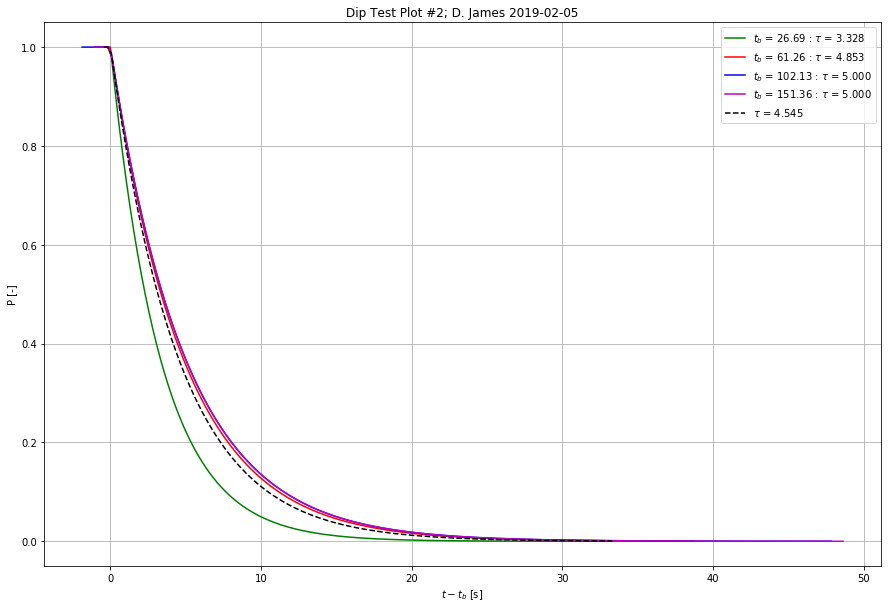

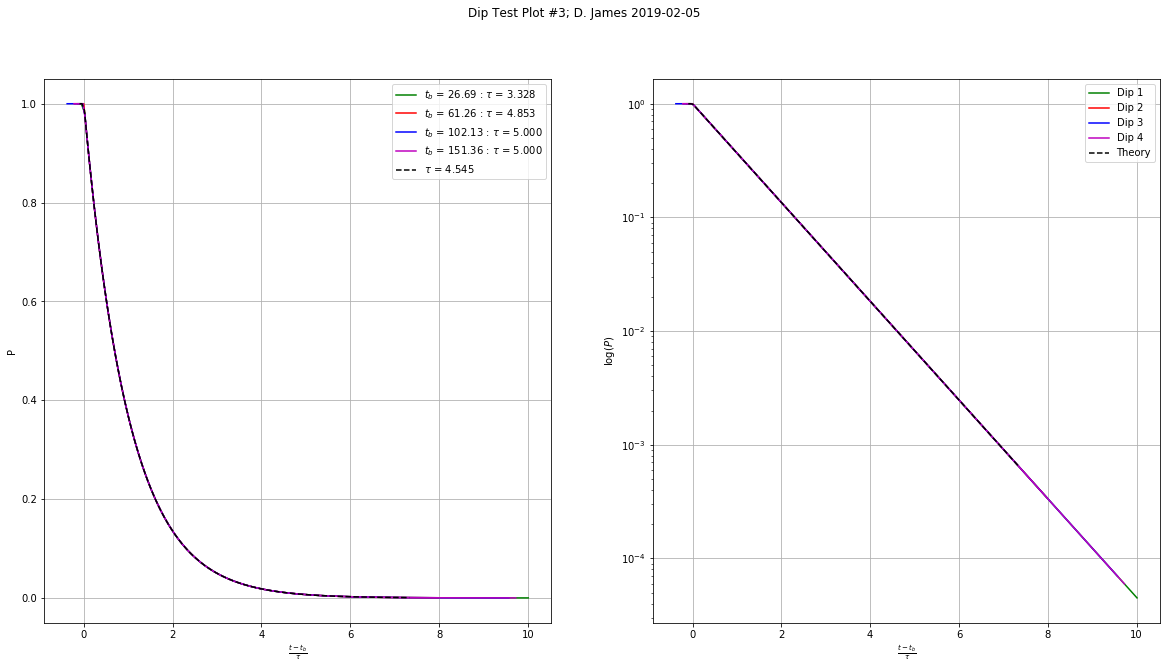

In [6]:
# list to hold parameters tau and tbreak
paramVals = []
# list to hold normalized values analyzed at minimized tau and tbreak
tModelVals = []

# the theoretical tau (treated within the for loop)
tauMean = 0

# figures to be plotted on
fig2 = plt.figure(num=2,figsize=(15,10))
fig3, ((ax1),(ax2)) = plt.subplots(1,2,figsize=(20,10))

for i in range(0,5):
    if(i != 4):
        # creating parameters and minimizing residuals
        params = Parameters()
        params.add('tau', value=3, max=5)
        params.add('tbreak',value=152, max=160)
        out = minimize(residual, params, args=(tempBreakout[i], timeBreakout[i], tempBreakout[i][0], tempBreakout[i][-1]))
        
        # appending parameters and model values analzed at parameters
        paramVals.append([out.params['tau'].value,out.params['tbreak'].value])
        tModelVals.append(tModel(paramVals[i][0],paramVals[i][1],timeBreakout[i]))
        
        # creating handle for functions to be plotted
        currentLabel = r'$t_b$ = %4.2f : $\tau$ = %4.3f' % (paramVals[i][1], paramVals[i][0])
        
        # plotting normalized model vs time graph
        plt.figure(2)
        plt.plot(timeBreakout[i]-paramVals[i][1],tModelVals[i],color[i+2],label=currentLabel)
        
        # plotting normalized model vs normalized time
        ax1.plot((timeBreakout[i]-paramVals[i][1])/paramVals[i][0],tModelVals[i],color[i+2],label=currentLabel)
        
        # plotting normalized log model vs normalized time
        ax2.semilogy((timeBreakout[i]-paramVals[i][1])/paramVals[i][0],tModelVals[i],color[i+2], label='Dip '+str(i+1))
    else:
        # getting theoretical tau
        tauMean = np.mean([paramVals[i][0] for i in range(0,4)])
        # evaluating normalized model at theoretical tau
        tModelVals.append(tModel(tauMean,paramVals[0][1],timeBreakout[0]))
        
        # plotting theoretical on plots
        currentLabel = r'$\tau$ = %4.3f' % (tauMean)
        plt.figure(2)
        plt.plot(timeBreakout[0]-paramVals[0][1],tModelVals[4],'k--',label=currentLabel)
        ax1.plot((timeBreakout[0]-paramVals[0][1])/tauMean,tModelVals[4],'k--',label=currentLabel)
        ax2.semilogy((timeBreakout[0]-paramVals[0][1])/tauMean,tModelVals[4],'k--',label='Theory')
        
# configuration for plot 2
plt.figure(2)
plt.title('Dip Test Plot #2; D. James ' + now)
plt.xlabel(r'$t - t_{b}$ [s]')
plt.ylabel('P [-]')
plt.grid(True)
plt.legend()

# configuration for left subplot
ax1.legend()
ax1.grid(True)
ax1.set_xlabel(r'$\frac{t-t_{b}}{\tau}$')
ax1.set_ylabel('P')

# configuration for right subplot
ax2.legend()
ax2.grid(True)
ax2.set_xlabel(r'$\frac{t-t_{b}}{\tau}$')
ax2.set_ylabel(r'$\log(P)$')

fig3.suptitle('Dip Test Plot #3; D. James ' + now)

# Problem 2

In [71]:
'''
Constants
kappa: thermal diffusivity [m/s^2]
omega: angular frequency [rad/s]
delta: scaling estimate for distance [m]
tau: scaling estimate for time [s]
Ti: initial temperature [C]
Tf: final temperature [C]
'''
kappa = 1e-6
omega = 2e-6
delta = np.sqrt(2*kappa/omega)
tau = 2*np.pi/omega
Ti = 0
Tf = 1

'''
Skin Depth Temperature Model T(t,z)
t: time [s]
z: distance [m]
returns temperature at that time and space
'''
def T(t,z):
    return Ti + (Tf-Ti)*np.exp(-1*z/delta)*np.cos(omega*t-z/delta)
def T_Border(z):
    return Ti + (Tf-Ti)*np.exp(-1*z/delta)

In [3]:
t = np.arange(0,tau,tau/20)
z = np.arange(0,6*delta,delta/20)
tt,zz = np.meshgrid(t,z)
tEval = T(tt,zz)

Text(0.5,1,'Prob #2; D. James 2019-02-07')

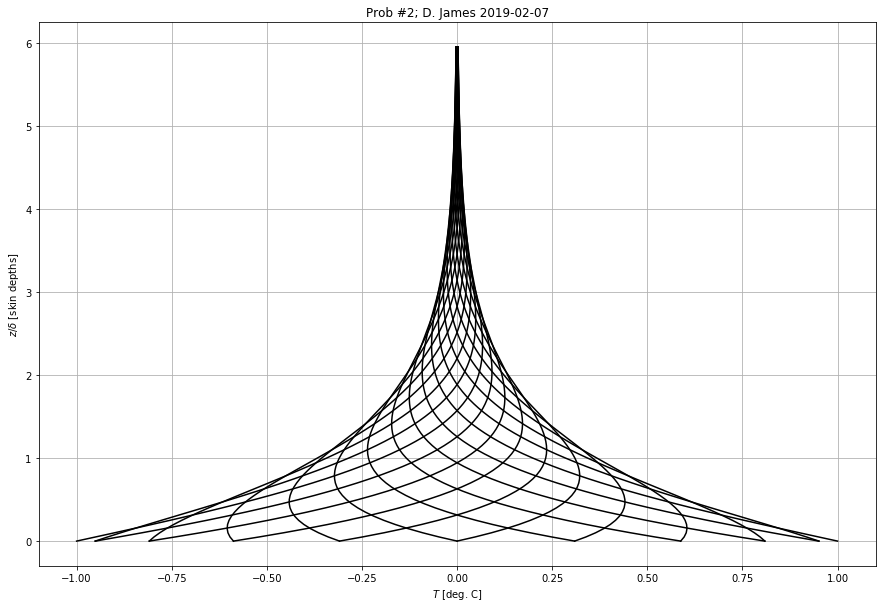

In [4]:
fig4 = plt.figure(figsize=(15,10))
for i in range(0,len(t)):
    plt.plot(tEval[:,i],z,'k')
    
plt.ylabel(r'$z/\delta$ [skin depths]')
plt.xlabel(r'$T$ [deg. C]')
plt.grid(True)
plt.title('Prob #2; D. James ' + now)


# Problem 3

In [16]:
t = np.arange(0,4*tau,tau/40)
z = np.arange(0,6*delta,delta/20)
tt,zz = np.meshgrid(t,z)
tEval = T(tt,zz)

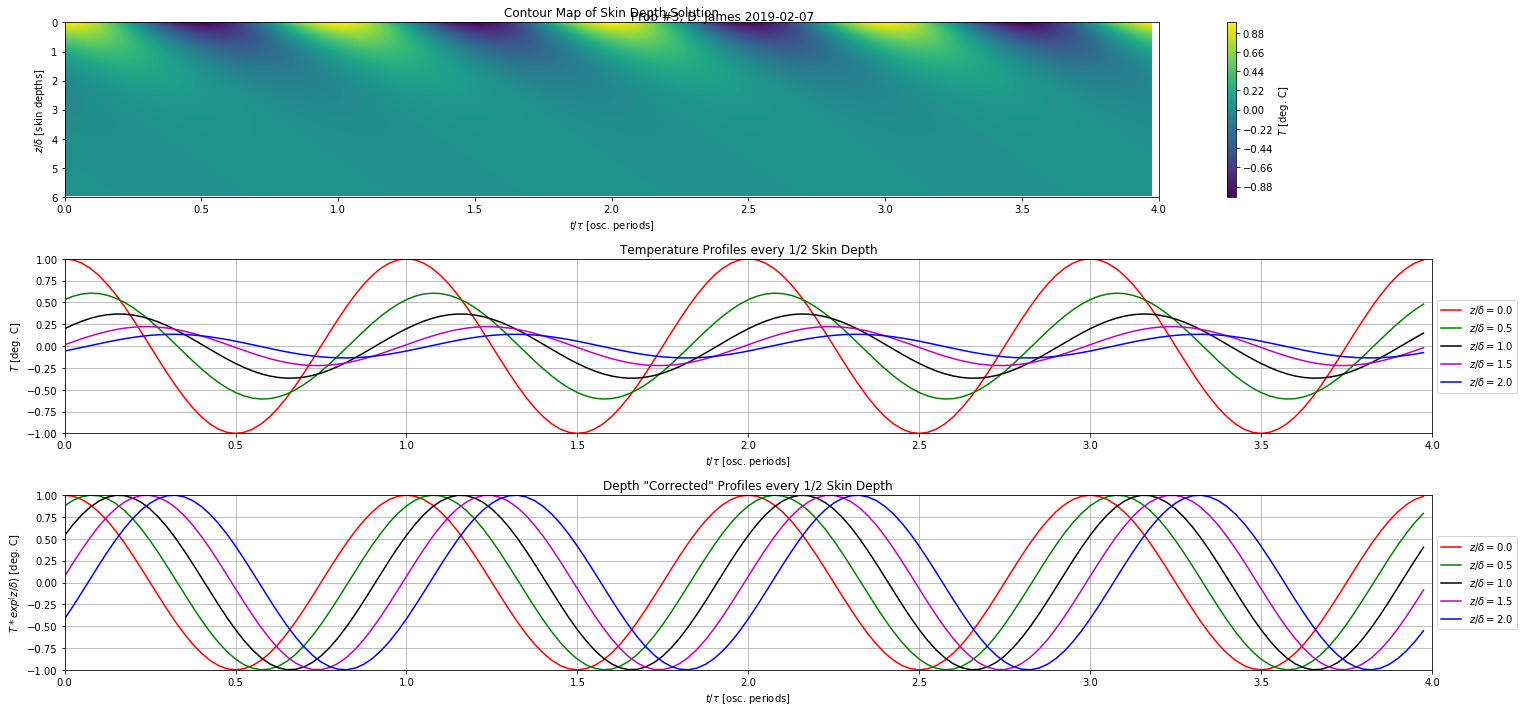

In [69]:
fig5, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(20,10))
colors = ['r','g','k','m','b']

sub1 = ax1.contourf(tt/tau,zz/delta,tEval,101)
cb = fig5.colorbar(sub1,ax=ax1)
ax1.axis([0,4,6,0])
ax1.set_title('Contour Map of Skin Depth Solution')
ax1.set_xlabel(r'$t/\tau$ [osc. periods]')
ax1.set_ylabel(r'$z/\delta$ [skin depths]')
cb.set_label(r'$T$ [deg. C]')

# step size of 10 for delta was divided by 20 above
# to get a z/delta at .5 markers
for i in range(0,50,10):
    ax2.plot(t/tau,tEval[i,:],colors[int(i/10)], label=r'$z/\delta=$'+str(z[i]/delta))

ax2.axis([0,4,-1,1])
ax2.set_title('Temperature Profiles every 1/2 Skin Depth')
ax2.set_xlabel(r'$t/\tau$ [osc. periods]')
ax2.set_ylabel(r'$T$ [deg. C]')
ax2.grid(True)
box = ax2.get_position()
ax2.set_position([box.x0,box.y0,box.width*.8,box.height])
ax2.legend(loc='center left', bbox_to_anchor=(1,0.5))

for i in range(0,50,10):
    correction = np.exp(z[i]/delta)
    ax3.plot(t/tau,tEval[i,:]*correction,colors[int(i/10)], label=r'$z/\delta=$'+str(z[i]/delta))

ax3.axis([0,4,-1,1])
ax3.set_title('Depth \"Corrected\" Profiles every 1/2 Skin Depth')
ax3.set_xlabel(r'$t/\tau$ [osc. periods]')
ax3.set_ylabel(r'$T*exp^(z/\delta)$ [deg. C]')
ax3.grid(True)
box = ax3.get_position()
ax3.set_position([box.x0,box.y0,box.width*.8,box.height])
ax3.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig5.suptitle('Prob #3; D. James ' + now)
plt.tight_layout()

# Problem 4

In [76]:
import cv2

In [72]:
t = np.arange(0,4*tau,tau/100)
z = np.arange(0,6*delta,delta/20)
tt,zz = np.meshgrid(t,z)
tEval = T(tt,zz)
tBorder = T_Border(z)

In [85]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter("output.avi", fourcc, 25, (640, 480))
open(video_writer)

TypeError: expected str, bytes or os.PathLike object, not cv2.VideoWriter

In [91]:
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    i = 0
    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    print(i)
    i += 1
    # Display the resulting frame
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

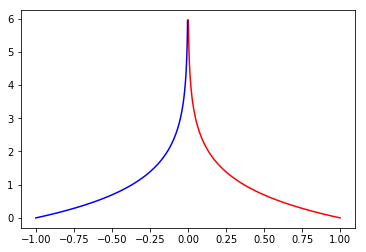

In [75]:
plt.plot(tBorder,z/delta,'r')
plt.plot(-1*tBorder,z/delta,'b')